In [1]:
#########1#########2#########3#########4#########5#########6#########7#########
import numpy as np
import pandas as pd

from scipy.optimize import minimize_scalar
from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
seds = pd.read_csv('data/seds_residents.csv')
seds['log_nu'] = np.log10(seds['Frequency (Hz)'])
seds['log_nufnu'] = np.log10(seds['Nufnu (erg cm^-2 s^-1)'])
#seds.head()

In [3]:
bzcat = pd.read_csv('data/BZCAT_RESULT.csv')

# "Mutual" source names for the datasets
bzcat['Source'] = bzcat.apply(lambda x:
    x['RA (J2000.0)'][0:2] + x['RA (J2000.0)'][3:5] + x['RA (J2000.0)'][6:8] \
    + x['Dec (J2000.0)'][0:3] + x['Dec (J2000.0)'][4:6] + x['Dec (J2000.0)'][7:9], 
    axis=1)
seds = pd.merge(seds, bzcat[['Source', 'Redshift', 'log_radio_lum', 'cluster']], on='Source')
#seds.head()

In [4]:
# To the rest frame
seds['log_nu'] = seds['log_nu'] + np.log10(1 + seds['Redshift'])
seds['log_nufnu'] = seds['log_nufnu'] + np.log10(1 + seds['Redshift'])
#seds.head()

In [5]:
# Synchrotron peak flux density
synch_peak = pd.read_csv('data/BZCAT_synch_withmax.csv')
synch_peak = synch_peak[synch_peak['Correct']]
seds = pd.merge(seds, synch_peak[['Source', 'Max_flux_density']], on='Source')
seds.head()

,Source,Frequency (Hz),Bin,Nufnu (erg cm^-2 s^-1),Nufnu_err,TStart,TStop,Comment,log_nu,log_nufnu,Redshift,log_radio_lum,cluster,Max_flux_density
0,000020-322101,8.430000e+08,0.0,2.710200e-15,8.261400e-17,50600.5,52974.5,NaN,9.282809,-14.210017,1.275,27.577721,4,-12.144045
1,000020-322101,1.400000e+09,0.0,7.299700e-15,2.190700e-16,49231.5,50508.5,NaN,9.503109,-13.779714,1.275,27.577721,4,-12.144045
2,000020-322101,2.700000e+09,0.0,1.458000e-14,0.000000e+00,40587.5,47892.5,NaN,9.788345,-13.479261,1.275,27.577721,4,-12.144045
3,000020-322101,2.700000e+09,0.0,1.458000e-14,0.000000e+00,0.0,0.0,NaN,9.788345,-13.479261,1.275,27.577721,4,-12.144045
4,000020-322101,4.850000e+09,0.0,2.594700e-14,1.891500e-15,48043.5,48196.5,NaN,10.042723,-13.228931,1.275,27.577721,4,-12.144045


In [6]:
def norm_spectrum(seds, source):
    "Normalized spectrum for a single source"
    #PEAK_RBOUND = 17.5 
    sed = seds[seds['Source'] == source].copy()#[['log_nu', 'log_nufnu', 'Max_flux_density']]
    #smax = sed[sed['log_nu'] < PEAK_RBOUND]['log_nufnu'].max()
    #sed['log_nufnu_norm'] = sed['log_nufnu'] - smax 
    sed['log_nufnu_norm'] = sed['log_nufnu'] - sed['Max_flux_density']
        
    return sed


def norm_spectra(seds, cluster):
    "Normalized spectra for a cluster"
    #PEAK_RBOUND = 17.5 
    seds = seds[seds['cluster'] == cluster].copy()#[['Source', 'log_nu', 'log_nufnu', 'Max_flux_density']]
    
    ## Max log_nufnu at log_nu < PEAK_RBOUND
    #seds['temp_col'] = seds['log_nufnu']
    #mask = seds['log_nu'] > PEAK_RBOUND
    #seds.loc[mask, 'temp_col'] = -np.inf
    #seds['max'] = seds.groupby('Source')['temp_col'].transform('max')
    #
    #seds['log_nufnu_norm'] = seds['log_nufnu'] - seds['max']
    
    seds['log_nufnu_norm'] = seds['log_nufnu'] - seds['Max_flux_density']
        
    return seds


def aver_spectrum(seds, cluster, bins=50):
    "Average spectrum for a cluster"
    seds = norm_spectra(seds, cluster)
    seds['center'] =(
        seds['log_nu']
        .groupby(pd.cut(np.array(seds['log_nu']), bins, include_lowest=True, labels=False)) # Bug in new pandas
        .transform('mean'))
    seds['mean'] =(
        seds['log_nufnu_norm']
        .groupby(pd.cut(np.array(seds['log_nu']), bins, include_lowest=True, labels=False))
        .transform('mean'))
    seds['std'] =(
        seds['log_nufnu_norm']
        .groupby(pd.cut(np.array(seds['log_nu']), bins, include_lowest=True, labels=False))
        .transform('std'))
    seds = seds.drop_duplicates(subset=['center', 'mean', 'std'])
    seds = seds.dropna(subset='std')
            
    return seds


def print_norm_spectra(seds):
    "Print normalized spectra per each cluster"
    norm_spectra_list = []
    clusters = sorted(seds['cluster'].unique())
    for cl in clusters: 
        norm_spectra_list.append(norm_spectra(seds, cl))
    n_cl = len(clusters)
    fig, ax = plt.subplots(1, n_cl, figsize=(8*n_cl, 5))
    for axi, cl in zip(ax.flatten(), clusters):
        axi.scatter(norm_spectra_list[cl]['log_nu'], 
                    norm_spectra_list[cl]['log_nufnu_norm'])
    fname = 'figs/all_measurements_norm.png' 
    plt.savefig(fname)    
        

def print_aver_spectra(seds, bins=50):
    "Print average spectrum per each cluster"
    aver_spectra = []
    clusters = sorted(seds['cluster'].unique())
    for cl in clusters: 
        aver_spectra.append(aver_spectrum(seds, cl, bins=bins))
    n_cl = len(clusters)
    fig, ax = plt.subplots(1, n_cl, figsize=(8*n_cl, 6), sharey=True)
    for axi, cl in zip(ax.flatten(), clusters):
        #axi.scatter(aver_spectra[cl]['log_nu'], aver_spectra[cl]['mean'])
        axi.errorbar(
            aver_spectra[cl]['center'], aver_spectra[cl]['mean'], 
            yerr=aver_spectra[cl]['std'], fmt='o', ms=8, mec='#333')
        axi.set_xlim([6.5, 28.5])
        axi.annotate(f'Cluster {cl}', xy=(7.5, 2), size=26)
        axi.tick_params(axis='both', which='major', labelsize=22)
        axi.set_xlabel(r'$\log \nu$, [Hz]', fontsize=26)
    ax[0].set_ylabel('Norm. flux density', fontsize=26)
    plt.tight_layout()
    
    fname = 'figs/aver_sp_bin' + str(bins) + '.png' 
    plt.savefig(fname)   
     

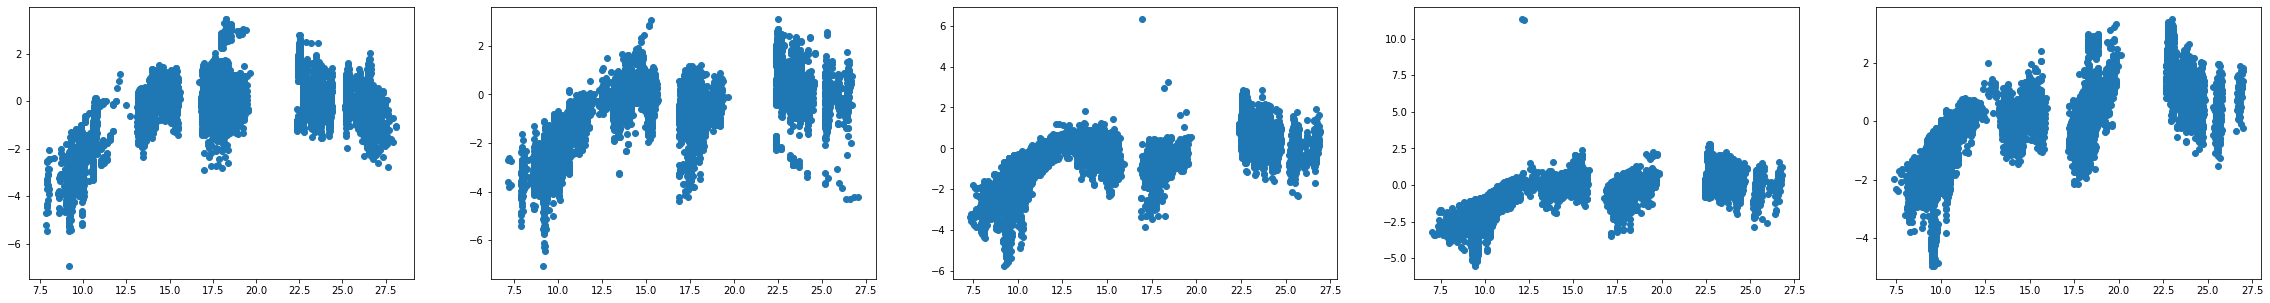

In [7]:
print_norm_spectra(seds)

In [8]:
# Drop outliers
norm_sp2 = norm_spectra(seds, 2)
norm_sp3 = norm_spectra(seds, 3)
print(norm_sp2[norm_sp2['log_nufnu_norm'] > 5]['Source'].unique())
print(norm_sp3[norm_sp3['log_nufnu_norm'] > 5]['Source'].unique())

seds = seds[seds['Source'] != '141558+132023']
seds = seds[seds['Source'] != '090910+012135']

['141558+132023']
['090910+012135']


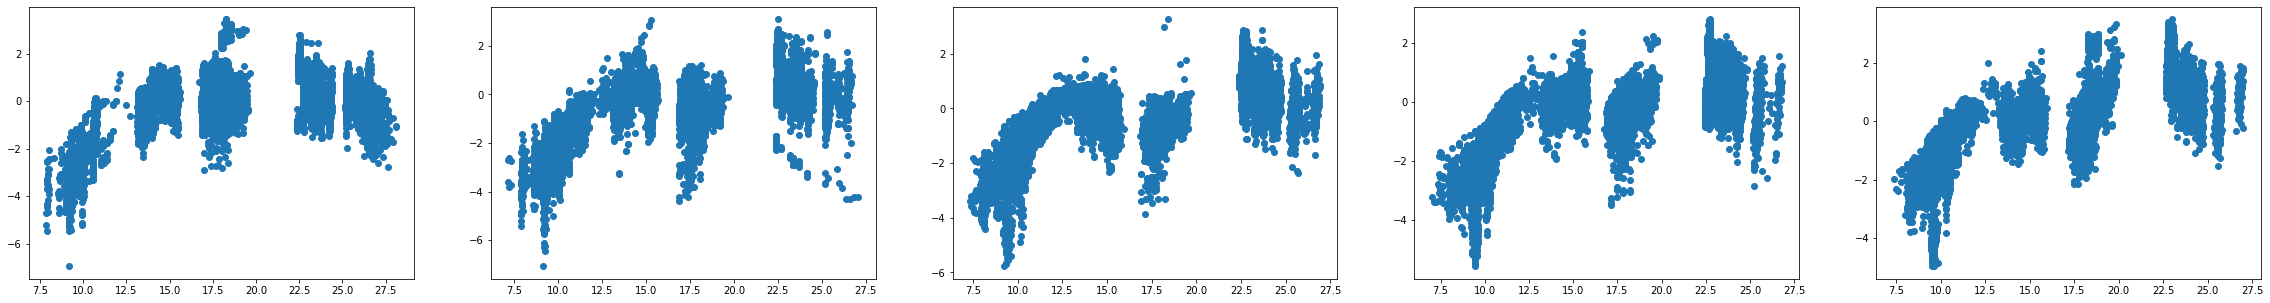

In [9]:
print_norm_spectra(seds)

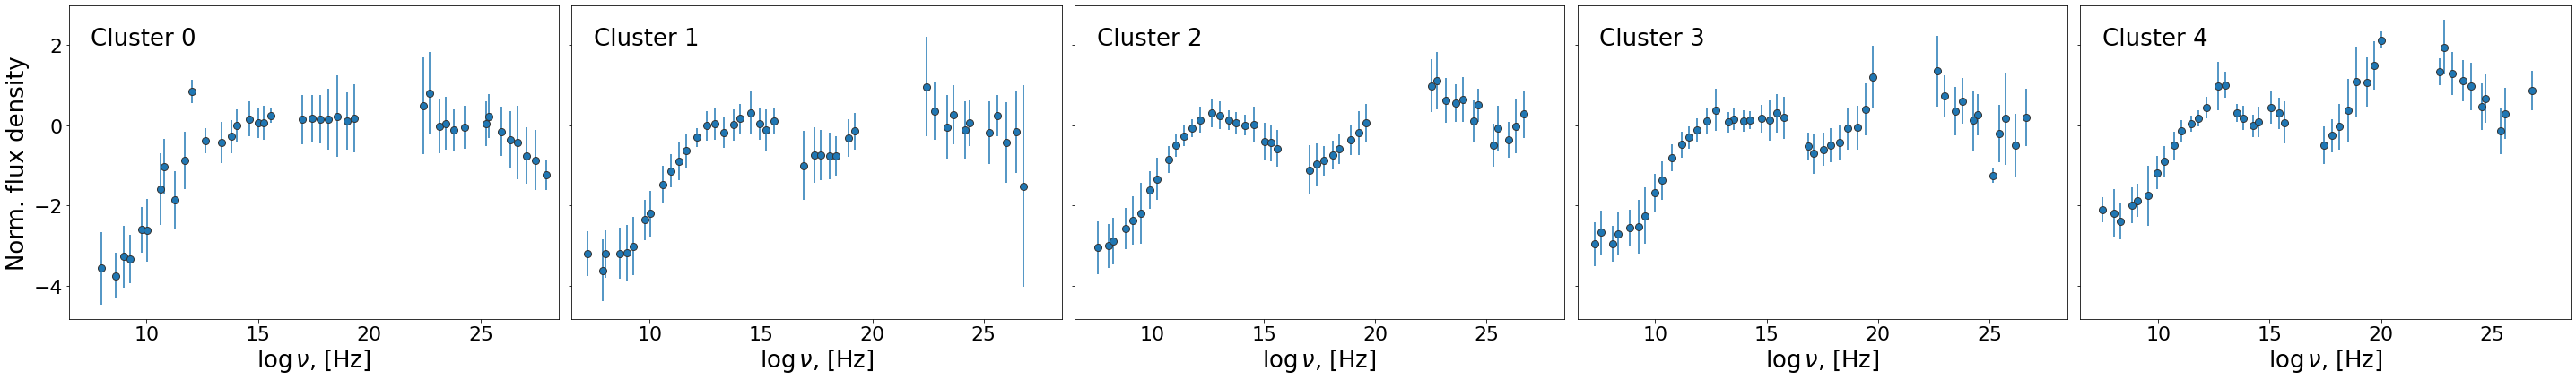

In [10]:
print_aver_spectra(seds, bins=50)

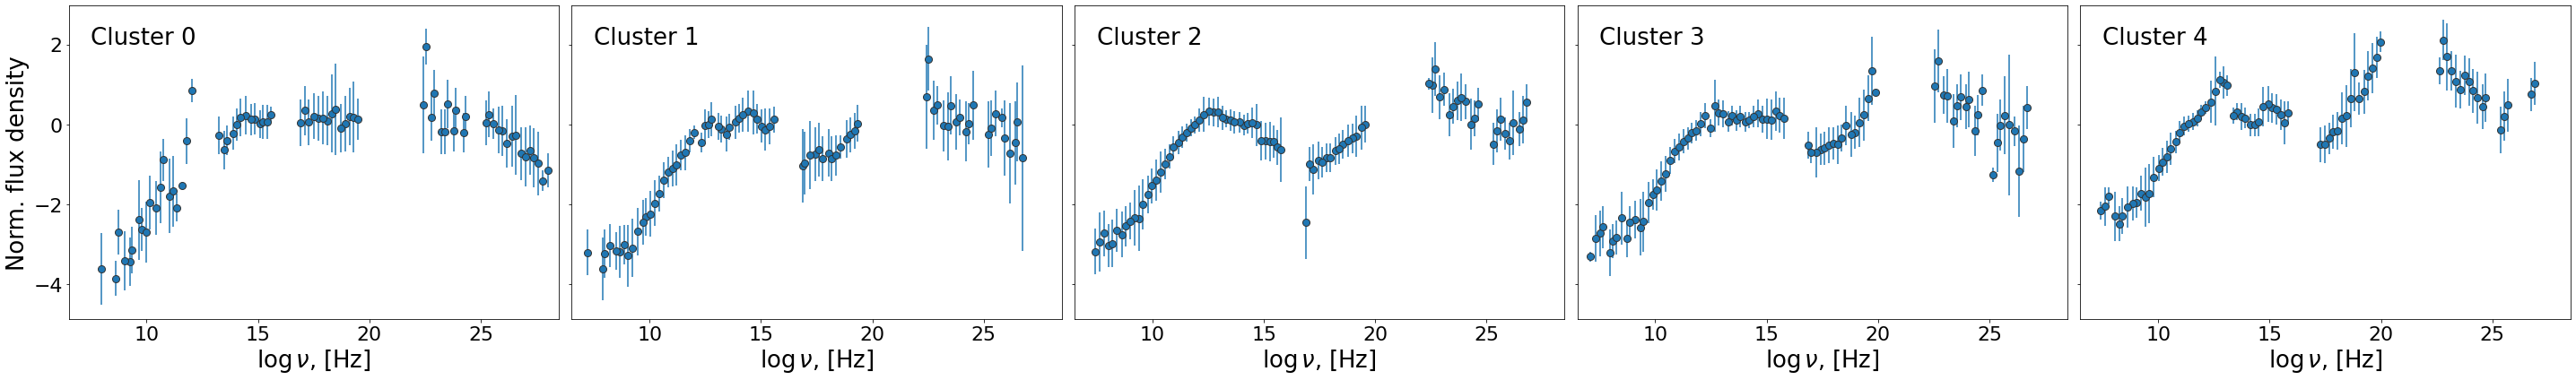

In [11]:
print_aver_spectra(seds, bins=100)

In [12]:
def poly_approx(x, y, degree, bounds):
    """Polynomial approximation"""
    def f(x):
        return -sum(w[i] * x**i for i in range(degree+1))
    
    features = [x**i for i in range(degree+1)]
    X = np.column_stack(features)
    w = np.linalg.inv(X.T@X) @ X.T @ y
    res = minimize_scalar(
        f, bounds=bounds, method='bounded')
    nu_extremum = res.x
    f_max = -f(nu_extremum)
    return nu_extremum, f_max, w

In [13]:
def plot_poly(cl, degree, bounds, bins, ax, lognu=None, log_nufnu=None):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    
    aversp = aver_spectrum(seds, cl, bins)[['center', 'mean', 'std']]

    # Adjust to flux density (luminosity) at a frequency
    if lognu is not None:
        log_nufnu_at_lognu = (
            aversp.iloc[(aversp['center'] - lognu).abs().argsort()[:1]]['mean']).iloc[0]
        aversp['mean'] = aversp['mean'] + (log_nufnu - log_nufnu_at_lognu)
    nu_extremum, f_max, w = poly_approx(
        aversp['center'], aversp['mean'], degree=degree, bounds=bounds)
    print(nu_extremum, f_max)
    
    x = np.linspace(bounds[0], bounds[1], 50)
    y = [sum(wval * xval**i for i, wval in enumerate(w)) for xval in x]
    #fig, ax = plt.subplots()
    ax.errorbar(
        aversp['center'], aversp['mean'], yerr=aversp['std'], 
        fmt='o', ms=8, mec='#333')
    ax.plot(x, y);
    # ax.axvline(x=13, 
    #         color='r', linestyle=':', linewidth=1)
    # ax.axvline(x=14.05, 
    #             color='r', linestyle=':', linewidth=1)
    # ax.axvline(x=14.44, 
    #             color='b', linestyle=':', linewidth=1)
    # ax.axvline(x=14.95, 
    #             color='b', linestyle=':', linewidth=1)
    # ax.text(13.3, -5., 'WISE', fontsize=12, rotation='vertical', color='r')
    # ax.text(14.4, -5., 'Pan-STARRS', fontsize=12, rotation='vertical', color='b')
    
    #return ax

21.12676468581046 0.434441496969157
13.745655419190953 0.0717791868029316
12.894580934933131 0.19761809914596284
13.404185272402929 0.2718150863469191
12.780107417057488 0.530671860130493


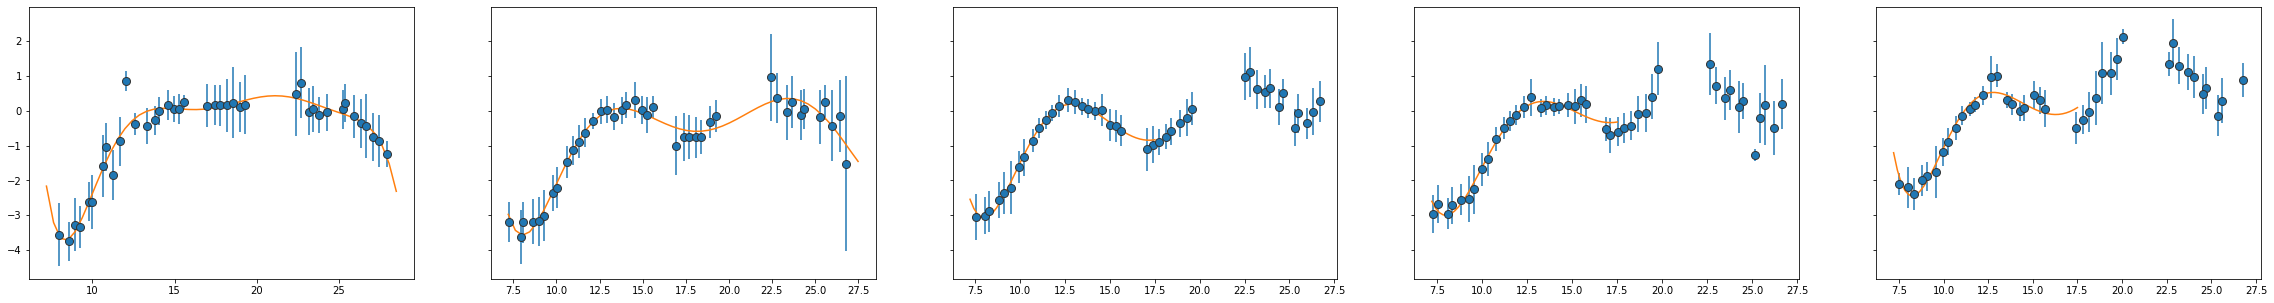

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(40, 5), sharey=True)
plot_poly(0, 7, (7.2, 28.5), 50, ax[0])
plot_poly(1, 7, (7.2, 27.5), 50, ax[1])
plot_poly(2, 7, (7.2, 17.5), 50, ax[2])
plot_poly(3, 7, (7.2, 17.5), 50, ax[3])
plot_poly(4, 7, (7.2, 17.5), 50, ax[4])

21.12676468581046 0.434441496969157
13.745655419190953 0.0717791868029316
22.46396918363321 0.9918770879169188
22.099788076203218 1.1617101516949333
21.82702630089293 1.9686812217424858


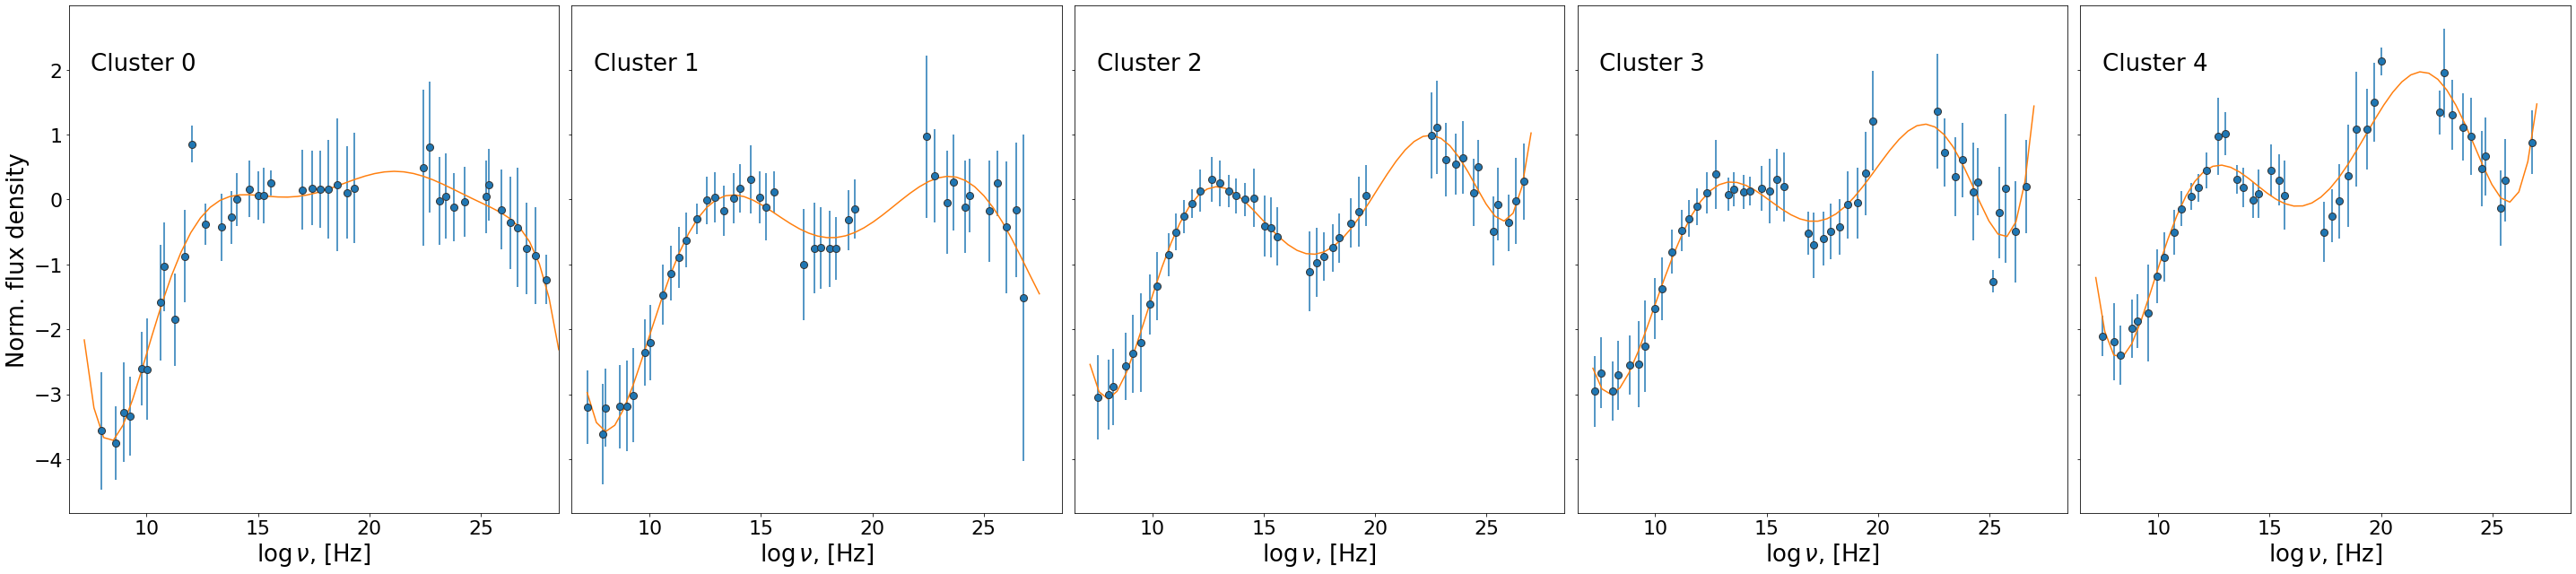

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(40, 6), sharey=True)
plot_poly(0, 7, (7.2, 28.5), 50, ax[0])
plot_poly(1, 7, (7.2, 27.5), 50, ax[1])
plot_poly(2, 7, (7.2, 27.0), 50, ax[2])
plot_poly(3, 7, (7.2, 27.0), 50, ax[3])
plot_poly(4, 7, (7.2, 27.0), 50, ax[4])
for axi, cl in zip(ax.flatten(), range(5)):
    axi.set_xlim([6.5, 28.5])
    axi.annotate(f'Cluster {cl}', xy=(7.5, 2), size=26)
    axi.tick_params(axis='both', which='major', labelsize=22)
    axi.set_xlabel(r'$\log \nu$, [Hz]', fontsize=26)
ax[0].set_ylabel('Norm. flux density', fontsize=26)
plt.tight_layout()
plt.savefig('figs/aver_sp_bin50_poly7.png') 

21.126802187146257 27.605706985340476
13.74590274540119 27.751866040312276
22.4638386186587 30.56763800105864
22.099651487299496 30.376922346220454
21.826899802288185 31.481463342987354


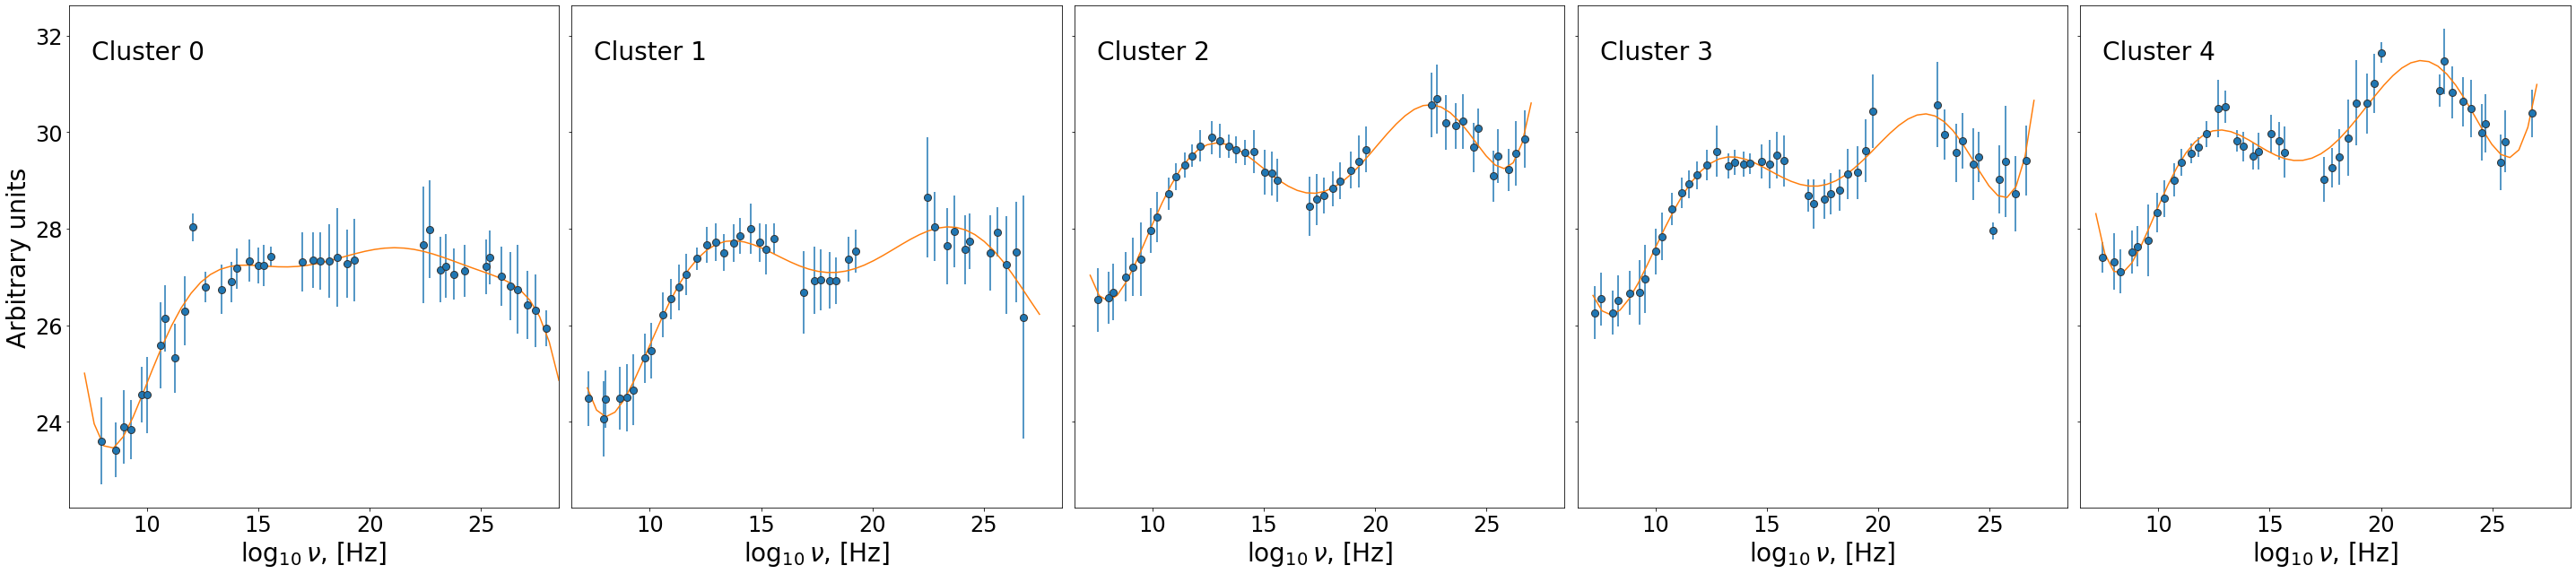

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(40, 9), sharey=True)
#plot_poly(0, 7, (7.2, 28.5), 50, ax[0], seds[seds['cluster'] == 0]['Max_flux_density'].mean())
#plot_poly(1, 7, (7.2, 27.5), 50, ax[1], seds[seds['cluster'] == 1]['Max_flux_density'].mean())
#plot_poly(2, 7, (7.2, 27.0), 50, ax[2], seds[seds['cluster'] == 2]['Max_flux_density'].mean())
#plot_poly(3, 7, (7.2, 27.0), 50, ax[3], seds[seds['cluster'] == 3]['Max_flux_density'].mean())
#plot_poly(4, 7, (7.2, 27.0), 50, ax[4], seds[seds['cluster'] == 4]['Max_flux_density'].mean())
lognu = np.log10(4.7e9)
plot_poly(0, 7, (7.2, 28.5), 50, ax[0], lognu, seds[seds['cluster'] == 0]['log_radio_lum'].median())
plot_poly(1, 7, (7.2, 27.5), 50, ax[1], lognu, seds[seds['cluster'] == 1]['log_radio_lum'].median())
plot_poly(2, 7, (7.2, 27.0), 50, ax[2], lognu, seds[seds['cluster'] == 2]['log_radio_lum'].median())
plot_poly(3, 7, (7.2, 27.0), 50, ax[3], lognu, seds[seds['cluster'] == 3]['log_radio_lum'].median())
plot_poly(4, 7, (7.2, 27.0), 50, ax[4], lognu, seds[seds['cluster'] == 4]['log_radio_lum'].median())

for axi, cl in zip(ax.flatten(), range(5)):
    axi.set_xlim([6.5, 28.5])
    axi.annotate(f'Cluster {cl}', xy=(7.5, 31.5), size=28)
    axi.tick_params(axis='both', which='major', labelsize=24)
    axi.set_xlabel(r'$\log_{10}\nu$, [Hz]', fontsize=28)
    
    #axi.axvline(x=13 + np.log10(1 + seds[seds['cluster'] == cl]['Redshift'].median()), 
    #        color='r', linestyle=':', linewidth=1.5)
    #axi.axvline(x=14.05 + np.log10(1 + seds[seds['cluster'] == cl]['Redshift'].median()), 
    #            color='r', linestyle=':', linewidth=1.5)
    #axi.axvline(x=14.44 + np.log10(1 + seds[seds['cluster'] == cl]['Redshift'].median()), 
    #            color='b', linestyle=':', linewidth=1.5)
    #axi.axvline(x=14.95 + np.log10(1 + seds[seds['cluster'] == cl]['Redshift'].median()), 
    #            color='b', linestyle=':', linewidth=1.5)
    # axi.text(13.2, -16.5, 'WISE', fontsize=22, rotation='vertical', color='r')
    # axi.text(14.3, -16.5, 'Pan-STARRS', fontsize=22, rotation='vertical', color='b')
    #if cl==0 or cl==1:
    #    axi.text(13.2, 23, 'WISE', fontsize=22, rotation='vertical', color='r')
    #    axi.text(14.3, 23, 'Pan-STARRS', fontsize=22, rotation='vertical', color='b')
    #elif cl==2 or cl==3:
    #    axi.text(13.5, 23, 'WISE', fontsize=22, rotation='vertical', color='r')
    #    axi.text(14.5, 23, 'Pan-STARRS', fontsize=22, rotation='vertical', color='b')
    #else:
    #    axi.text(13.7, 23, 'WISE', fontsize=22, rotation='vertical', color='r')
    #    axi.text(14.7, 23, 'Pan-STARRS', fontsize=22, rotation='vertical', color='b')
    
#ax[0].set_ylabel('$\\log_{10} \\nu F_{\\nu}$, [erg cm$^{-2}$ s$^{-1}$]', fontsize=26)
#ax[0].set_ylabel('$\\log_{10}L_{4.7}$, [W/Hz]', fontsize=26)
ax[0].set_ylabel('Arbitrary units', fontsize=28)
plt.tight_layout()
plt.savefig('figs/aver_sp_bin50_poly7_unnorm.png') 
plt.savefig('figs/aver_sp_bin50_poly7_unnorm.eps')

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

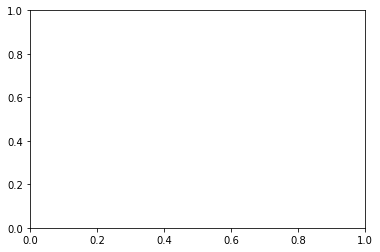

In [23]:
fig, ax = plt.subplots()
#plot_poly(0, 7, (7.2, 28.5), 50, ax, seds[seds['cluster'] == 0]['Max_flux_density'].mean())
plot_poly(1, 7, (7.2, 27.5), 50, ax, seds[seds['cluster'] == 1]['Max_flux_density'].mean())
plot_poly(2, 7, (7.2, 27.0), 50, ax, seds[seds['cluster'] == 2]['Max_flux_density'].mean())
#plot_poly(3, 7, (7.2, 27.0), 50, ax, seds[seds['cluster'] == 3]['Max_flux_density'].mean())
#plot_poly(4, 7, (7.2, 27.0), 50, ax, seds[seds['cluster'] == 4]['Max_flux_density'].mean())

In [ ]:
def plot_spline(cl, degree, bins, ax, log_nufnu=None):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    
    aversp = (aver_spectrum(seds, cl, bins)[['center', 'mean', 'std']]
              .sort_values(by='center'))
    if log_nufnu is not None:
        aversp['mean'] = aversp['mean'] + log_nufnu
        
    spl = make_interp_spline(aversp['center'], aversp['mean'], k=degree)
    x = np.linspace(aversp['center'].min(), aversp['center'].max(), 150)
    y = spl(x)
        
    ax.errorbar(
        aversp['center'], aversp['mean'], yerr=aversp['std'], 
        fmt='o', ms=8, mec='#333')
    ax.plot(x, y);

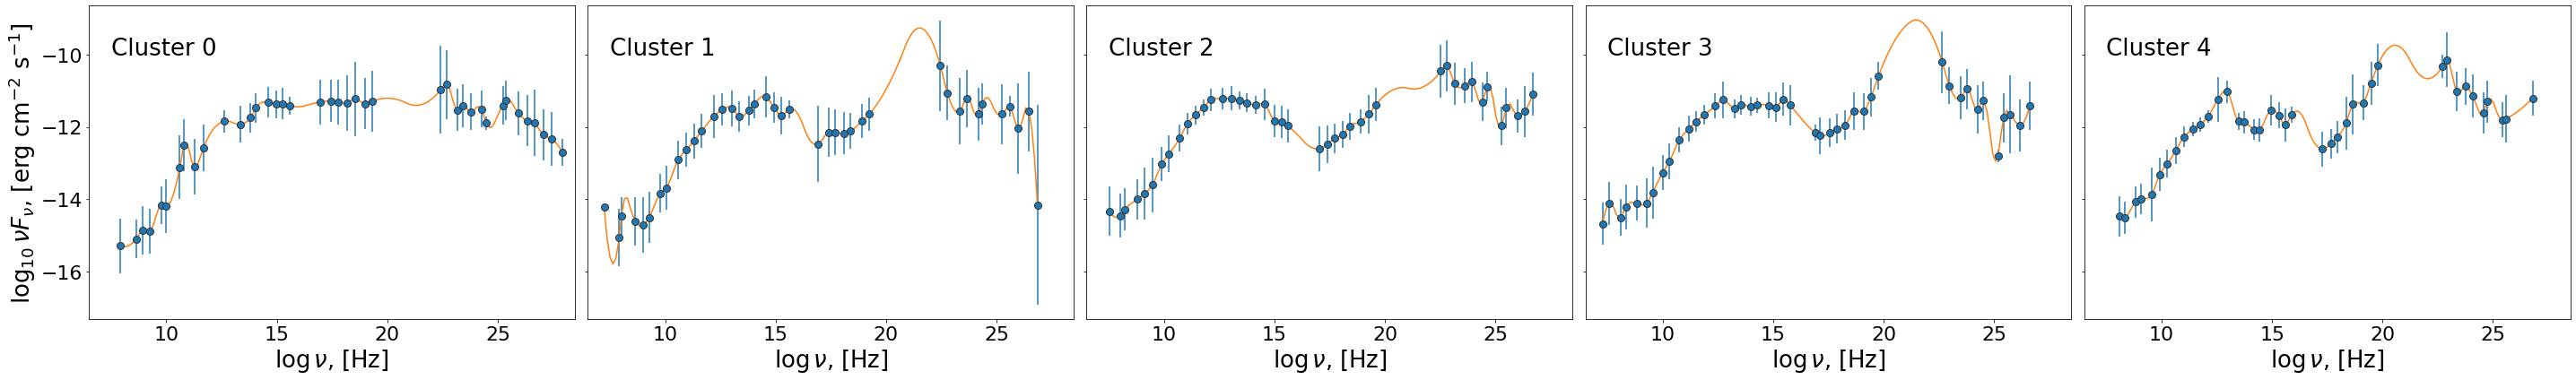

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(40, 6), sharey=True)
plot_spline(0, 2, 50, ax[0], seds[seds['cluster'] == 0]['Max_flux_density'].mean())
plot_spline(1, 2, 50, ax[1], seds[seds['cluster'] == 1]['Max_flux_density'].mean())
plot_spline(2, 2, 50, ax[2], seds[seds['cluster'] == 2]['Max_flux_density'].mean())
plot_spline(3, 2, 50, ax[3], seds[seds['cluster'] == 3]['Max_flux_density'].mean())
plot_spline(4, 2, 50, ax[4], seds[seds['cluster'] == 4]['Max_flux_density'].mean())
for axi, cl in zip(ax.flatten(), range(5)):
    axi.set_xlim([6.5, 28.5])
    axi.annotate(f'Cluster {cl}', xy=(7.5, -10), size=26)
    axi.tick_params(axis='both', which='major', labelsize=22)
    axi.set_xlabel(r'$\log \nu$, [Hz]', fontsize=26)
ax[0].set_ylabel('$\\log_{10} \\nu F_{\\nu}$, [erg cm$^{-2}$ s$^{-1}$]', fontsize=26)
plt.tight_layout()
plt.savefig('figs/aver_sp_bin50_spline2_unnorm.png') 

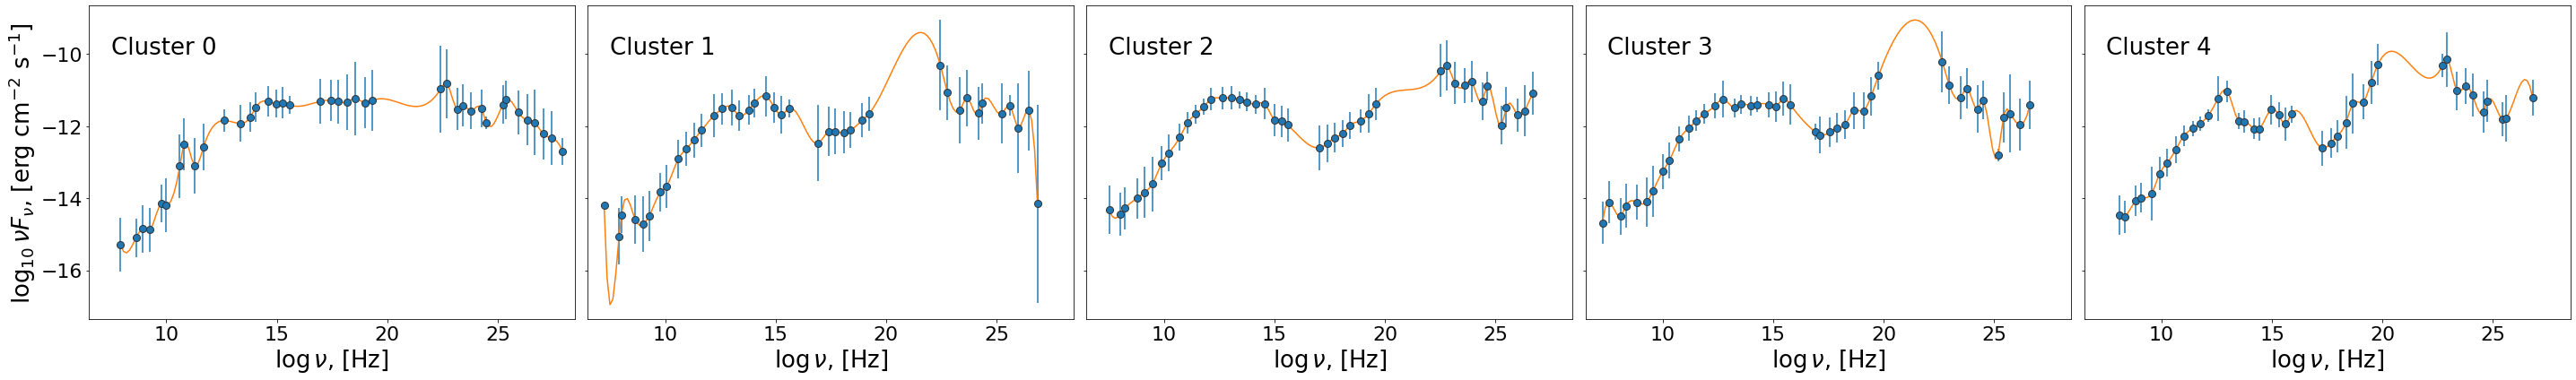

In [21]:
fig, ax = plt.subplots(1, 5, figsize=(40, 6), sharey=True)
plot_spline(0, 3, 50, ax[0], seds[seds['cluster'] == 0]['Max_flux_density'].mean())
plot_spline(1, 3, 50, ax[1], seds[seds['cluster'] == 1]['Max_flux_density'].mean())
plot_spline(2, 3, 50, ax[2], seds[seds['cluster'] == 2]['Max_flux_density'].mean())
plot_spline(3, 3, 50, ax[3], seds[seds['cluster'] == 3]['Max_flux_density'].mean())
plot_spline(4, 3, 50, ax[4], seds[seds['cluster'] == 4]['Max_flux_density'].mean())
for axi, cl in zip(ax.flatten(), range(5)):
    axi.set_xlim([6.5, 28.5])
    axi.annotate(f'Cluster {cl}', xy=(7.5, -10), size=26)
    axi.tick_params(axis='both', which='major', labelsize=22)
    axi.set_xlabel(r'$\log \nu$, [Hz]', fontsize=26)
ax[0].set_ylabel('$\\log_{10} \\nu F_{\\nu}$, [erg cm$^{-2}$ s$^{-1}$]', fontsize=26)
plt.tight_layout()
plt.savefig('figs/aver_sp_bin50_spline3_unnorm.png') 
plt.savefig('figs/aver_sp_bin50_spline3_unnorm.eps')